## Task 0: import data

1. Create folder called data next to main.ipynb
1. Create file called .gitignore next to main.ipynb. In this write: data/
1. Download data between 01-01-2021 and 01-01-2022
    1. Nordpool - hourly prices in DKK
    1. Bornholm network manager - kirkeby Sose Vindpark Active Power
    1. Digital Energy Lab/Weather Observations/DMI - All streams from Bornholm
1. Place data files under /data and rename to production, prices, and weather

## TO-DO
1. Implement validation for hyperparameter tuning. K-fold?
1. Implement task 7
1. Implement model 2
    1. Run optimizer on training set, feed to regressor insted of production
    1. Try classification and regression

## Task 1: Optimization model

In [1]:
import gurobipy as gp
import numpy as np
from gurobipy import GRB

# Create optimization model for bidding strategy in DA and balancing market
# Fixed price and production arrays

lambda_DA = [65.3, 72.1, 80.5, 67.8, 55.9, 64.2, 78.4, 71.3, 85.1, 90.5, 63.4, 70.9, 
             68.1, 75.6, 83.3, 69.4, 61.2, 66.7, 76.5, 82.2, 59.8, 72.4, 88.0, 73.9]  # Day-ahead market prices (EUR/MWh)

lambda_up = [9.4, 11.3, 130.5, 10.9, 90.8, 108.2, 115.9, 103.4, 128.5, 132.2, 104.1, 
             109.6, 120.7, 112.3, 138.4, 121.9, 109.3, 118.7, 126.8, 137.5, 102.5, 
             116.9, 141.6, 115.4]  # Upward regulation prices (EUR/MWh)

lambda_down = [25.4, 32.6, 45.2, 30.1, 23.9, 27.8, 33.7, 31.4, 40.5, 38.1, 27.2, 35.4, 
               29.3, 31.9, 44.1, 36.7, 26.4, 34.7, 41.5, 39.9, 28.5, 37.6, 43.7, 33.1]  # Downward regulation prices (EUR/MWh)

P_proj = [82.3, 77.4, 92.1, 84.6, 65.2, 70.1, 88.3, 79.5, 90.9, 95.4, 69.8, 83.2, 
          76.9, 81.7, 89.2, 85.0, 67.5, 73.8, 91.1, 94.5, 62.3, 78.9, 93.4, 81.5]  # Realized production (MW)

def market_bid(lambda_DA, lambda_up, lambda_down, P_proj,  C = 6500):
    
    t = len(P_proj)
    #### Create model ####
    model = gp.Model()

    #### Decision variables ####
    # Production/bid in DA market
    P_bid = model.addVars(t, lb = 0, ub = C, vtype=GRB.CONTINUOUS, name="P_bid")

    # Binary variables for upward and downward regulation
    u = model.addVars(t, vtype=GRB.BINARY, name="upward_regulation")  # Binary for upward regulation
    d = model.addVars(t, vtype=GRB.BINARY, name="downward_regulation")  # Binary for downward regulation

    #### Set Constraints ####

    # Ensure that the wind farm is either in upward or downward regulation. 
    model.addConstrs((u[i] + d[i] == 1 for i in range(t)), "regulation")

    # Only allow upward or downward regulation to be non-zero when the respective binary is active.  
    model.addConstrs((lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] >= 0 for i in range(t)), "upward_nonzero")
    model.addConstrs((lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] >= 0 for i in range(t)), "downward_nonzero")


    #### Set Objective ####
    model.setObjective(
        gp.quicksum(lambda_DA[i] * P_bid[i] for i in range(t)) + 
        gp.quicksum(lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] - lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] for i in range(t)),
        GRB.MAXIMIZE
    )

    #### Optimize ####
    model.setParam('OutputFlag', 0)
    model.optimize()


    #### Print results ####
    bid = model.getAttr("X", P_bid)
    bid = np.array([bid[i] for i in range(t)])
    return bid


P_bid = market_bid(lambda_DA, lambda_up, lambda_down, P_proj)
print(P_bid)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-10
[6500.  6500.    92.1 6500.    65.2   70.1   88.3   79.5   90.9   95.4
   69.8   83.2   76.9   81.7   89.2   85.    67.5   73.8   91.1   94.5
   62.3   78.9   93.4   81.5]


## Task 2: Data collection

Want to determine some features that we believe will be useful predictors of future wind power. Could be previous wind power, features of the weather, season or similar. First step is to load data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Import and format relevant data 
# Import production data
production = pd.read_csv('data/production.csv')
production['ts'] = pd.to_datetime(production['ts']) # Convert to datetime
production = production.set_index('ts') # Set datetime as index
production = production.resample('h').mean() # Resample to hourly data
production = production.rename(columns={"kirkeby Sose Vindpark Active Power | aki_sov_effekt | 804128": "power"}) # Rename column
#production = production.fillna(0) # Fill missing values with 0
production = -1 * production # Change sign to positive for production

# Import weather data
weather = pd.read_csv('data/weather.csv')
weather['ts'] = pd.to_datetime(weather['ts'])
weather = weather.set_index('ts')
weather = weather.resample('h').mean()
#weather = weather.fillna(0)

# Import electricity prices
prices = pd.read_csv('data/prices.csv',  decimal=',')
prices['ts'] = pd.to_datetime(prices['ts'])
prices = prices.set_index('ts')


# Import balance prices
balance = pd.read_csv('./data/balance.csv', decimal=',')
balance = balance[balance["PriceArea | PriceArea | 804696"] == "DK2"]
balance['ts'] = pd.to_datetime(balance['ts'])
balance = balance.set_index('ts')
balance.drop(columns = ["PriceArea | PriceArea | 804696"], inplace = True)
balance = balance.shift(1) # Shift data one hour to align with production data


# Merge data
inputdata = pd.concat([production, weather, prices, balance], join='inner', axis=1)

# Rename columns for easier access
inputdata = inputdata.rename(columns = {
    "Observed mean humidity past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/humidity_past1h/06193 | 406576": "humidity_Hammer_Odde",
    "Observed maximum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_max_past1h/06193 | 406592" : "temp_max_Hammer_Odde",
    "Observed accumulated precipitation the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/precip_past1h/06197 | 406528": "precipitation_Nex",
    "Observed mean wind speed the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/wind_speed_past1h/06197 | 406512": "windspeed_Nex",
    "Observed maximum temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_max_past1h/06197 | 406464": "temp_max_Nex",
    "Observed mean intensity of global radiation in the latest hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/radia_glob_past1h/06193 | 406672": "global_radiation_Hammer_Odde",
    "Observed minimum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_min_past1h/06193 | 406608": "temp_min_Hammer_Odde",
    "Observed minimum temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_min_past1h/06197 | 406480": "temp_min_Nex",
    "Observed mean temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_mean_past1h/06193 | 406560": "temp_mean_Hammer_Odde",
    "Observed mean temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_mean_past1h/06197 | 406432": "temp_mean_Nex",
    "Observed mean humidity past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/humidity_past1h/06197 | 406448": "humidity_Nex",
    "Observed mean wind speed the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_speed_past1h/06193 | 406640": "windspeed_Hammer_Odde",
    "Observed mean wind direction the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/wind_dir_past1h/06197 | 406496": "winddirection_Nex",
    "Observed accumulated precipitation the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/precip_past1h/06193 | 406656": "precipitation_Hammer_Odde",
    "Observed mean intensity of global radiation in the latest hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/radia_glob_past1h/06197 | 406544": "global_radiation_Nex",
    "Observed mean wind direction the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_dir_past1h/06193 | 406624": "winddirection_Hammer_Odde",
    "Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820": "spotprice",
    "BalancingPowerPriceUpDKK | BalancingPowerPriceUpDKK | 804719": "lambda_up",
    "BalancingPowerPriceDownDKK | BalancingPowerPriceDownDKK | 804721" : "lambda_down"
})


Inspection shows holes in the data. Further looking into the data shows that these are typically in windows of exactly 24 hours or integer multiples of this with 0 or near 0 values. We remove these for more representative data for the model

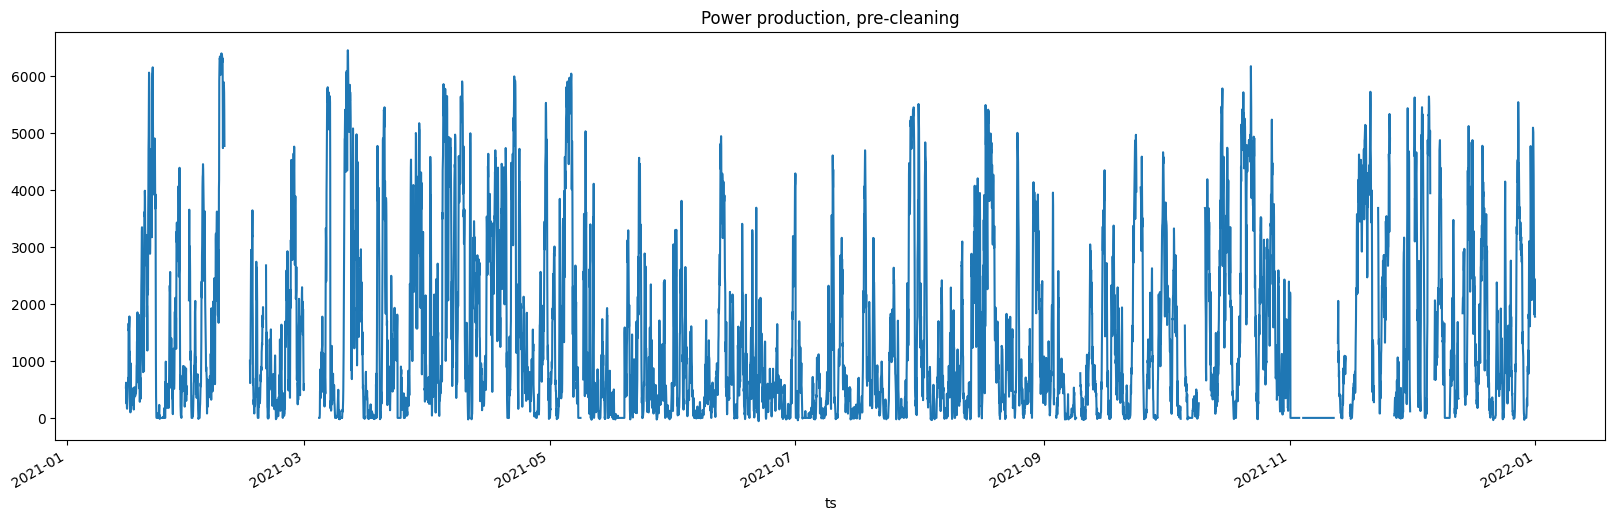

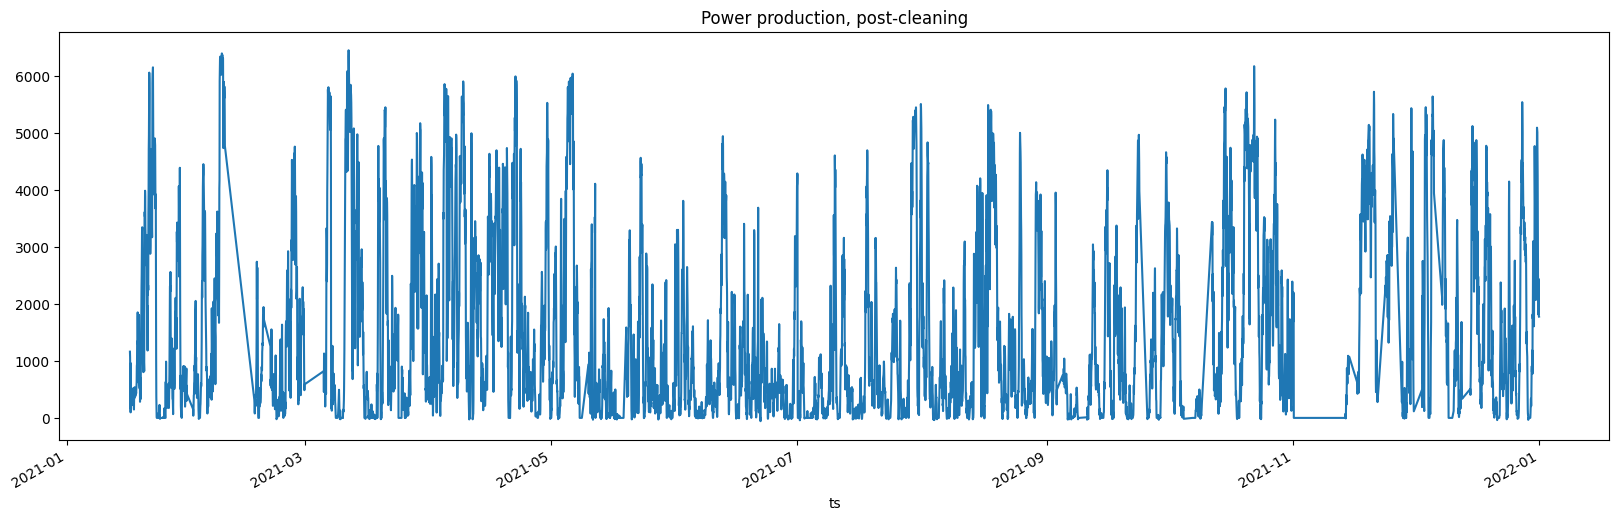

In [3]:
plt.figure(figsize=(20, 6))
inputdata["power"].plot(title = "Power production, pre-cleaning")
plt.show()

mask = inputdata["power"].rolling(window=24).sum() > 24*0.3
inputdata = inputdata.loc[mask]
plt.figure(figsize=(20, 6))
inputdata["power"].plot(title = "Power production, post-cleaning")
plt.show()

Next we add potential features

In [4]:
### Add more potential features ###
# Add hour, weekend and month as features
inputdata['hour'] = inputdata.index.hour
inputdata['weekend'] = inputdata.index.weekday > 4
inputdata['month'] = inputdata.index.month

### Add lagged power as features ###
# Add mean power production the day before as feature
daily_power = inputdata['power'].resample('D')
mean_power_lag1D = daily_power.mean().shift(1)
inputdata['mean_power_lag1D'] = inputdata.index.normalize().map(mean_power_lag1D)

# Add variance of power production the day before as feature
var_power_lag1D = daily_power.var().shift(1)
inputdata['var_power_lag1D'] = inputdata.index.normalize().map(var_power_lag1D)

# Add mean power production the week before as feature
weekly_mean_power = inputdata['power'].resample('W').mean()
mean_power_lag1W = weekly_mean_power.shift(1)
#inputdata['mean_power_lag1W'] = inputdata.index.normalize().map(mean_power_lag1W)

### Add lagged prices as features ###
# Add mean spot price the day before as feature
daily_prices = inputdata["spotprice"].resample('D')
mean_prices_lag1D = daily_prices.mean().shift(1)
inputdata['mean_prices_lag1D'] = inputdata.index.normalize().map(mean_prices_lag1D)

# Add variance of spot price the day before as feature
var_prices_lag1D = daily_prices.var().shift(1)
inputdata['var_prices_lag1D'] = inputdata.index.normalize().map(var_prices_lag1D)

# Add spot price lagged 24 hours as feature
prices_lag24H = inputdata["spotprice"].shift(24)
inputdata['prices_lag24H'] = inputdata.index.normalize().map(prices_lag24H)

# Add mean balancing price yesterday as feature
mean_lambda_up_lag1D = inputdata["lambda_up"].resample('D').mean().shift(1)
inputdata['mean_lambda_up_lag1D'] = inputdata.index.normalize().map(mean_lambda_up_lag1D)

mean_lambda_down_lag1D = inputdata["lambda_down"].resample('D').mean().shift(1)
inputdata['mean_lambda_down_lag1D'] = inputdata.index.normalize().map(mean_lambda_down_lag1D)

# Add mean difference between spotprice and balance prices as feature
mean_diff_up_lag1D = (mean_prices_lag1D - mean_lambda_up_lag1D)
inputdata['mean_diff_up_lag1D'] = inputdata.index.normalize().map(mean_diff_up_lag1D)

mean_diff_down_lag1D = (mean_prices_lag1D - mean_lambda_down_lag1D)
inputdata['mean_diff_down_lag1D'] = inputdata.index.normalize().map(mean_diff_down_lag1D)

### Interpolate missing values and remove NaNs ###
inputdata = inputdata.interpolate()
inputdata = inputdata.dropna()

We can then check correlation of the features with the power. Correlation could indicate that the feature is useful in regression

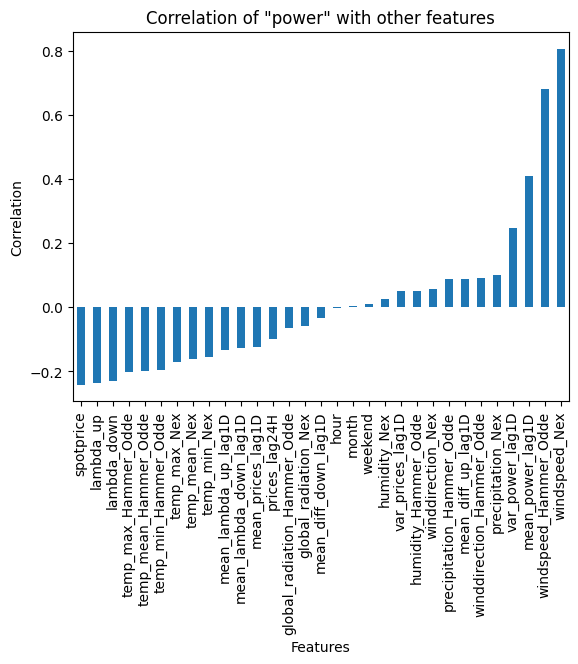

In [5]:
# Check correlation between features
inputdata.corr().iloc[1:, 0].sort_values().plot(kind='bar')
plt.title('Correlation of "power" with other features')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

Look closer at features with correlation > 0.2

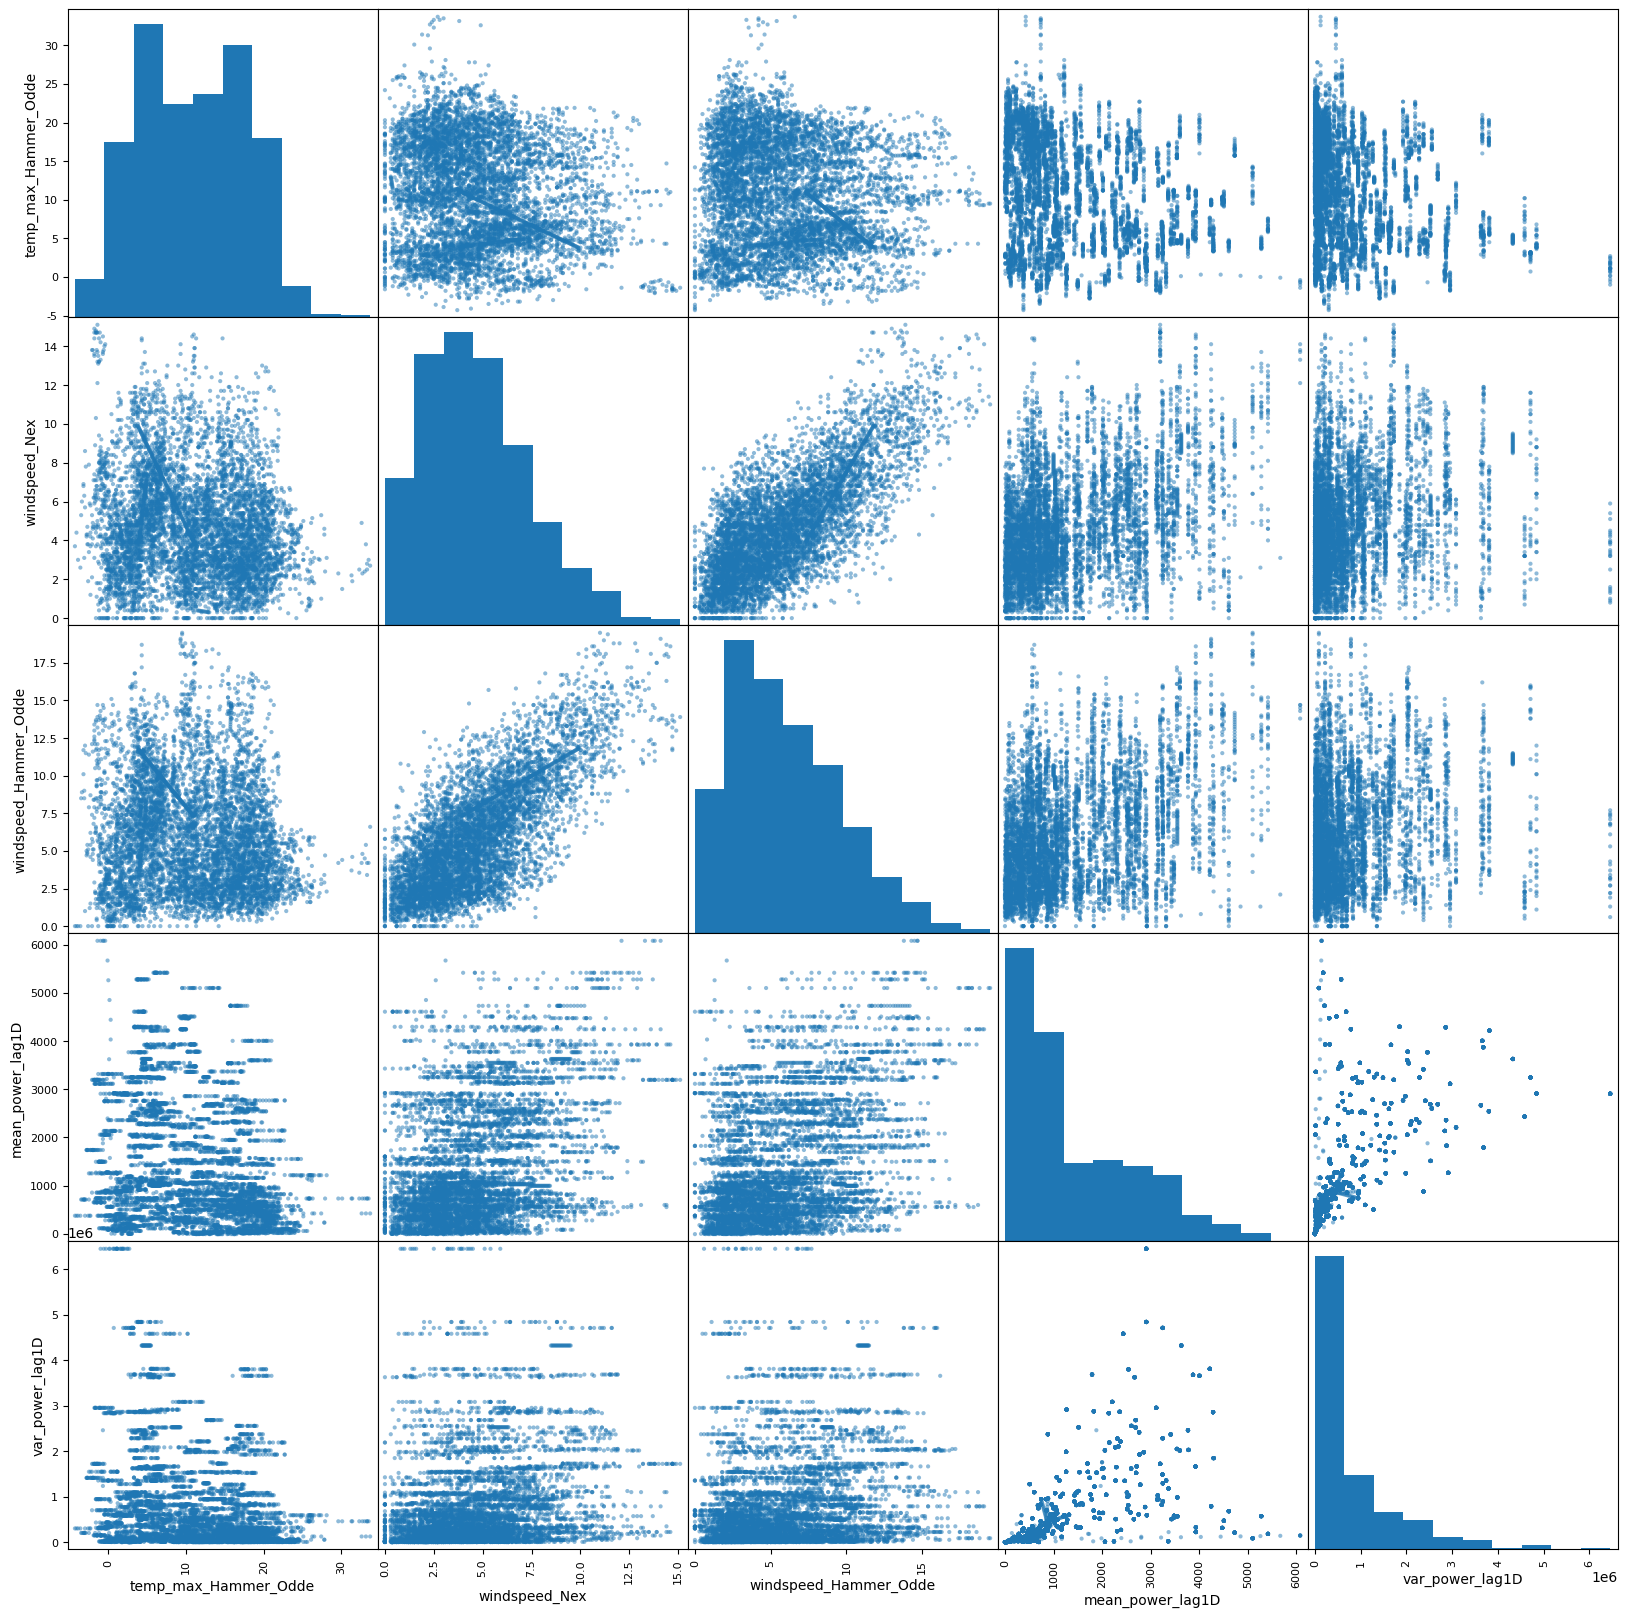

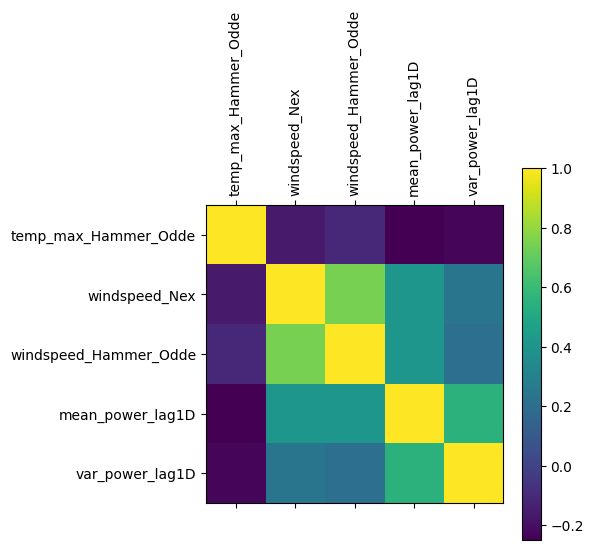

In [6]:
corr = inputdata.corr().iloc[1:, 0]
corr = corr[abs(corr) > 0.2]
features = corr.index

# Drop prices as we do not know these in advance
features = features.drop(['spotprice', 'lambda_up', 'lambda_down'])
pd.plotting.scatter_matrix(inputdata[features], figsize=(20, 20))
plt.show()

plt.matshow(inputdata[features].corr())
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.colorbar()
plt.show()


In [7]:
# Select features with correlation > 0.2
x = inputdata[features]
y = inputdata['power'][x.index]

# Print selected features
print(x.columns)

Index(['temp_max_Hammer_Odde', 'windspeed_Nex', 'windspeed_Hammer_Odde',
       'mean_power_lag1D', 'var_power_lag1D'],
      dtype='object')


In [8]:
# Scale data 
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Add bias term to input data
X = np.concatenate([np.ones((x.shape[0], 1)), x_scaled], axis=1)

# Split data into training and test set for time series data
test_train_fraction = 0.80
split_index = int(len(x) * test_train_fraction)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Further split training data into training and validation data
train_validation_fraction = 0.80
split_index = int(len(X_train) * train_validation_fraction)
X_train_train, X_train_val = X_train[:split_index], X_train[split_index:]
y_train_train, y_train_val = y_train[:split_index], y_train[split_index:]

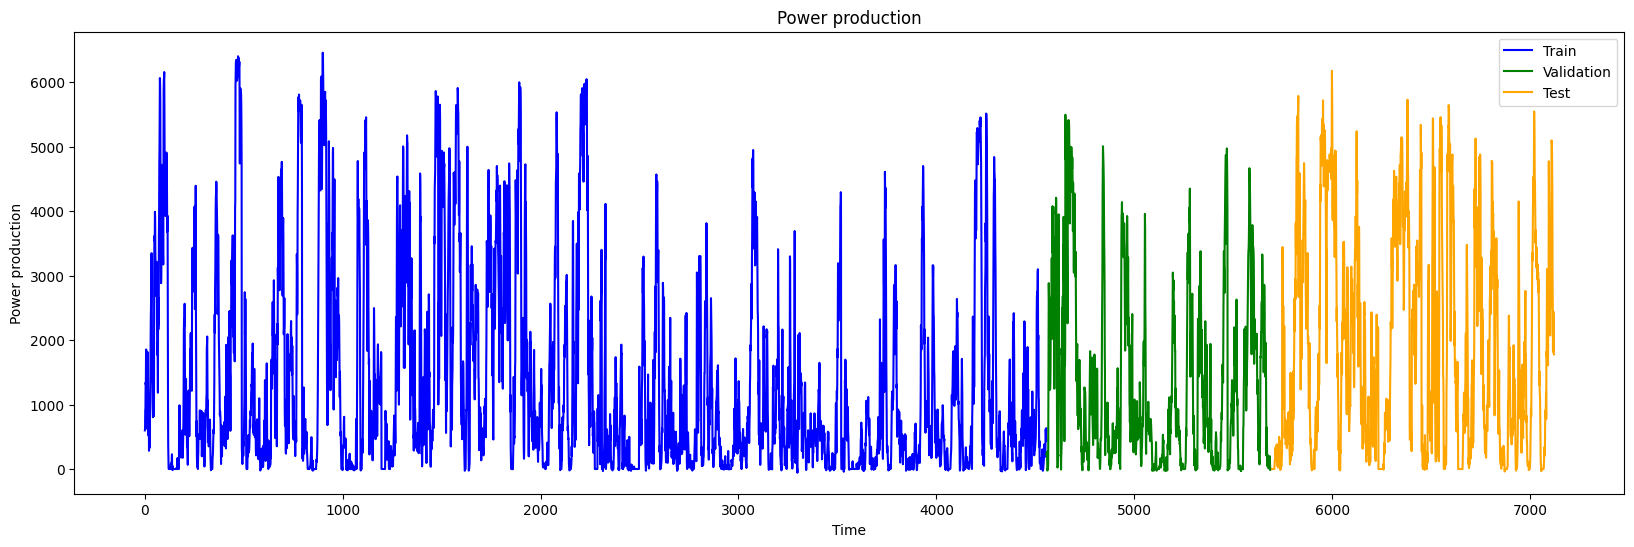

In [9]:
# Plot target variable against time, split into training and test set
plt.figure(figsize=(20, 6))
plt.plot(np.arange(len(y_train_train)), y_train_train, label='Train', color='blue')
plt.plot(np.arange(len(y_train_train), len(y_train_train)+ len(y_train_val)), y_train_val, label='Validation', color='green')
plt.plot(np.arange(len(y_train), len(y_train)+ len(y_test)), y_test, label='Test', color = 'orange')
plt.legend()
plt.title('Power production')
plt.xlabel('Time')
plt.ylabel('Power production')
plt.show()

## Task 3: Linear Regression

In [10]:
# Implement gradient descent
def gradient_descent(X_train, y_train, max_iterations=10000, alpha = 0.01):
    # Initial guess of coefficients
    theta = np.zeros(X_train.shape[1])

    # Number of observations
    m = len(X_train)
    
    for _ in range(max_iterations):

        # Linear regression prediction
        h = theta @ X_train.T

        # The partial derivatives of the cost function
        dt = (1/m) * ((h - y_train.T) @ X_train)

        # Update the coefficients
        theta = theta - alpha * dt

        # Break if the change in coefficients is small
        if np.linalg.norm(alpha * dt) < 1e-6:
            return theta
        
    return theta


# Implement closed form solution
theta_cfs = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Compare the two solutions
print(gradient_descent(X_train, y_train))
print(theta_cfs)


[1425.12780438  -76.9311989  1017.98677516  216.08552883  113.09307303
    2.37489511]
[1425.1277775   -76.93117213 1017.98708845  216.08520477  113.0930524
    2.37491461]


RMSE: 944.9841459487145
MAE: 727.7270618237225
R2: 0.6789680440295304


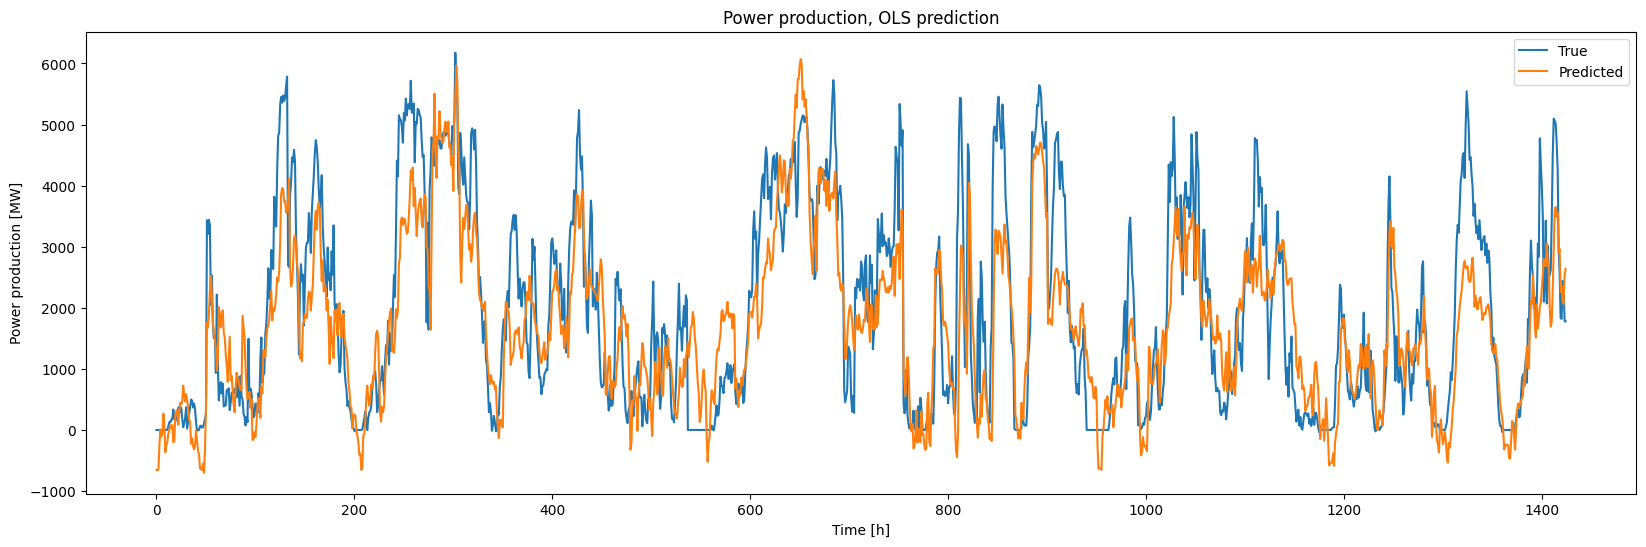

In [11]:
# Evaluate model
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions
y_OLS = X_test @ theta_cfs

# Calculate metrics
rmse = np.sqrt(np.mean((y_test - y_OLS)**2))
mae = mean_absolute_error(y_test, y_OLS)
r2 = r2_score(y_test, y_OLS)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

# Plot predictions
test_index = np.arange(len(y_test))
plt.figure(figsize=(20, 6))
plt.plot(test_index, y_test, label='True')
plt.plot(test_index, y_OLS, label='Predicted')
plt.legend()
plt.title('Power production, OLS prediction')
plt.xlabel('Time [h]')
plt.ylabel('Power production [MW]')
plt.show()

## Task 4: Non-linear regression

[ 1.42394456e+03 -1.30464668e+02  1.01568193e+03  2.20708833e+02
  1.10448777e+02  3.17078143e-01  2.54647078e+01]
RMSE: 945.5443649662509
MAE: 727.3584683797989
R2: 0.6785872936903081


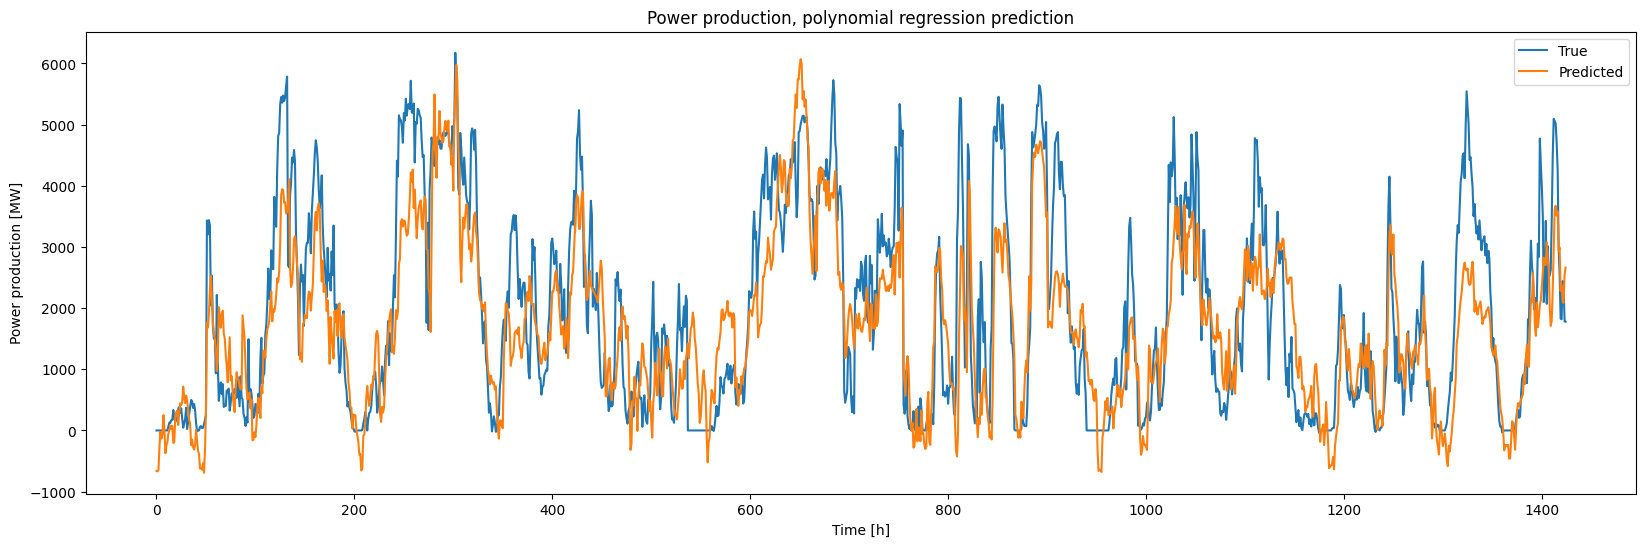

In [12]:
# 4.1: Implement polynomial regression
# Add wind speed as a second degree polynomial
x_train_poly = np.concatenate([X_train, np.power(X_train[:, 1:2], 3)], axis=1)
x_test_poly = np.concatenate([X_test, np.power(X_test[:, 1:2], 3)], axis=1)

theta_poly = np.linalg.inv(x_train_poly.T @ x_train_poly) @ x_train_poly.T @ y_train

y_poly = x_test_poly @ theta_poly
print(theta_poly)

# Calculate metrics
rmse_poly = np.sqrt(np.mean((y_test - y_poly)**2))
mae_poly = mean_absolute_error(y_test, y_poly)
r2_poly = r2_score(y_test, y_poly)

print(f"RMSE: {rmse_poly}")
print(f"MAE: {mae_poly}")
print(f"R2: {r2_poly}")


plt.figure(figsize=(20, 6))
plt.plot(test_index, y_test, label='True')
plt.plot(test_index, y_poly, label='Predicted')
plt.legend()
plt.title('Power production, polynomial regression prediction')
plt.xlabel('Time [h]')
plt.ylabel('Power production [MW]')
plt.show()


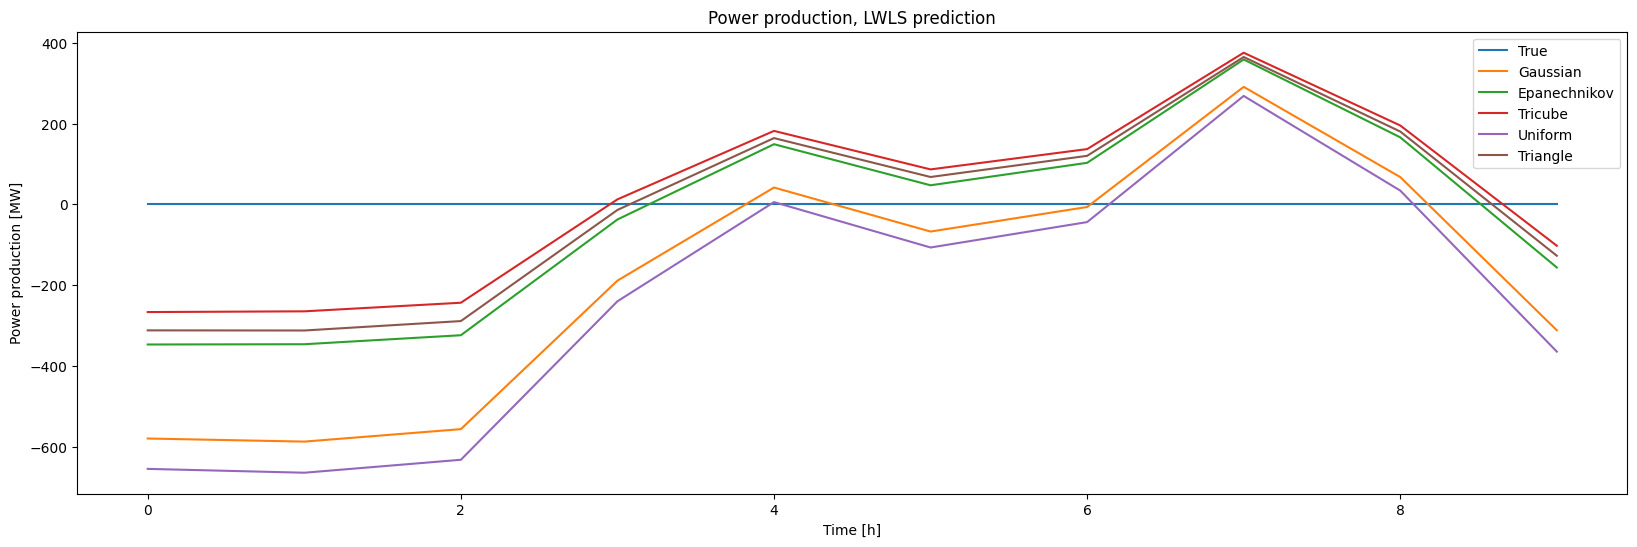

In [13]:
# 4.2: Implement weighted least squares
# Possible kernels
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return kern

def tricube(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return kern

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return kern


# Implement locally weighted least squares
def lwls(X_train, y_train, X_test, kernel=gaussian, bandwidth=0.1):
    y_pred = np.zeros(X_test.shape[0])
    for i, x in enumerate(X_test):
        # Calculate weights
        weights = kernel(np.linalg.norm(X_train - x, axis=1) / bandwidth)
        W = np.diag(weights)
        
        # Calculate theta
        theta = np.linalg.inv(X_train.T @ W @ X_train) @ X_train.T @ W @ y_train
        
        # Make prediction
        y_pred[i] = x @ theta
        
    return y_pred

# Make predictions
n = 10
band = 5
y_lwls_gauss = lwls(X_train, y_train, X_test[:n], kernel=gaussian, bandwidth=band)
y_lwls_epan = lwls(X_train, y_train, X_test[:n], kernel=epanechnikov, bandwidth=band)
y_lwls_tricube = lwls(X_train, y_train, X_test[:n], kernel=tricube, bandwidth=band)
y_lwls_uniform = lwls(X_train, y_train, X_test[:n], kernel=uniform, bandwidth=band)
y_lwls_triangle = lwls(X_train, y_train, X_test[:n], kernel=triangle, bandwidth=band)

# Plot predictions
plt.figure(figsize=(20, 6))
plt.plot(test_index[:n], y_test[:n], label='True')
plt.plot(test_index[:n], y_lwls_gauss, label='Gaussian')
plt.plot(test_index[:n], y_lwls_epan, label='Epanechnikov')
plt.plot(test_index[:n], y_lwls_tricube, label='Tricube')
plt.plot(test_index[:n], y_lwls_uniform, label='Uniform')
plt.plot(test_index[:n], y_lwls_triangle, label='Triangle')
plt.legend()
plt.title('Power production, LWLS prediction')
plt.xlabel('Time [h]')
plt.ylabel('Power production [MW]')
plt.show()

## Task 5: Regularization

In [14]:
from sklearn.linear_model import Lasso, Ridge

def regularization_tuning(X_train, y_train, X_val, y_val, method, alphas):
    rmse = []
    mae = []
    for alpha in alphas:
        if method == 'Lasso':
            reg = Lasso(alpha=alpha)
        elif method == 'Ridge':
            reg = Ridge(alpha=alpha)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_val)
        rmse.append(np.sqrt(np.mean((y_val - y_pred)**2)))
        mae.append(mean_absolute_error(y_val, y_pred))
    
    plt.plot(alphas, rmse, label='RMSE')
    plt.plot(alphas, mae, label='MAE')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Error')
    plt.legend()
    plt.title(f'{method} regularization tuning')
    plt.show()

    # Return best alpha according to mean of RMSE and MAE
    best_alpha = alphas[np.argmin(np.mean([rmse, mae], axis=0))]
    return best_alpha

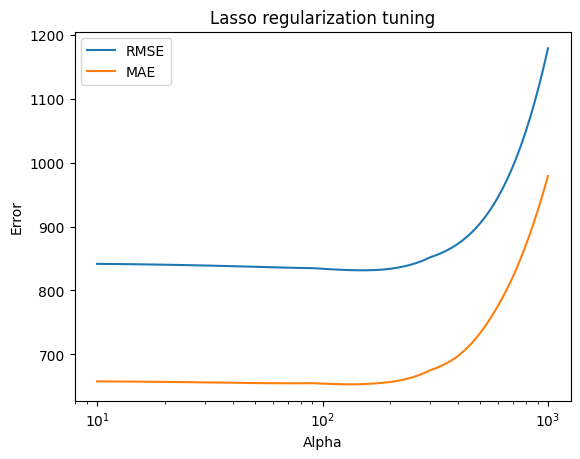

Optimal alpha for lasso: 141.74741629268047


In [15]:
opt_alpha_lasso = regularization_tuning(X_train_train, y_train_train, X_train_val, y_train_val, 'Lasso', np.logspace(1, 3, 100))
print(f'Optimal alpha for lasso: {opt_alpha_lasso}')

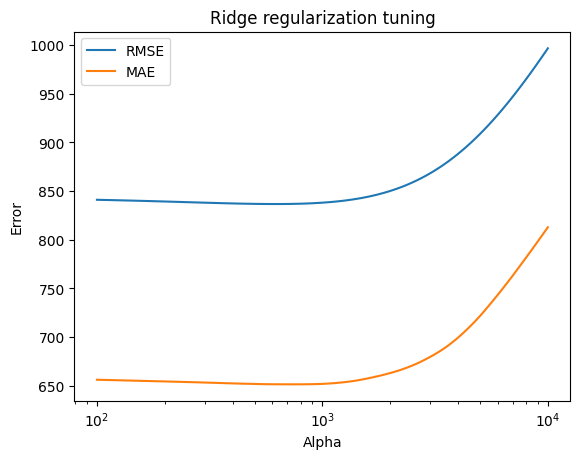

Optimal alpha for ridge: 642.807311728432


In [16]:
opt_alpha_ridge = regularization_tuning(X_train_train, y_train_train, X_train_val, y_train_val, 'Ridge', np.logspace(2, 4, 100))
print(f'Optimal alpha for ridge: {opt_alpha_ridge}')

RMSE Lasso: 1010.5664200129293
MAE Lasso: 775.9472048945698
[  0.          -0.         989.8650401  121.93508768  32.19955428
   0.        ]
RMSE Ridge: 958.2318575587565
MAE Ridge: 734.1520700325493
[  0.         -85.00957541 845.77696102 304.56758425 126.69721442
  13.11287797]


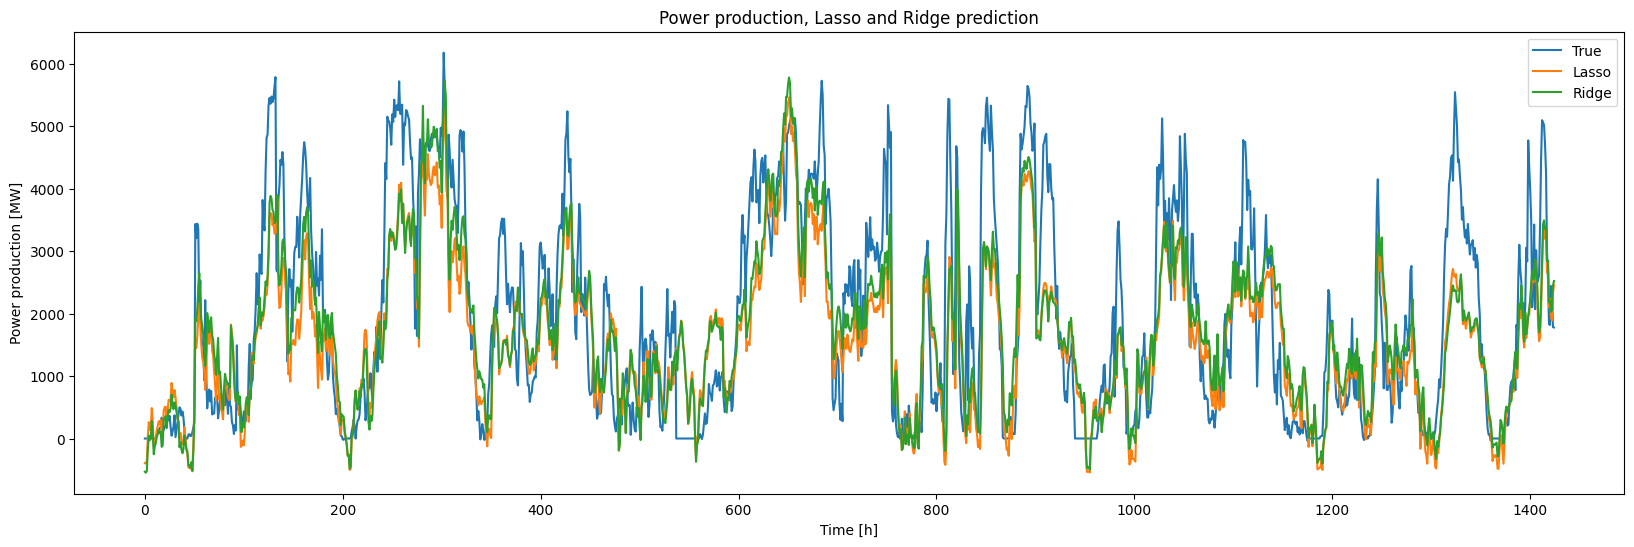

In [17]:
# Implement Lasso regression
lasso = Lasso(alpha=opt_alpha_lasso)
lasso.fit(X_train, y_train)
y_lasso = lasso.predict(X_test)

# Implement Ridge regression
ridge = Ridge(alpha=opt_alpha_ridge)
ridge.fit(X_train, y_train)
y_ridge = ridge.predict(X_test)

# Evaluate models
rmse_lasso = np.sqrt(np.mean((y_test - y_lasso)**2))
mae_lasso = mean_absolute_error(y_test, y_lasso)

rmse_ridge = np.sqrt(np.mean((y_test - y_ridge)**2))
mae_ridge = mean_absolute_error(y_test, y_ridge)

print(f"RMSE Lasso: {rmse_lasso}")
print(f"MAE Lasso: {mae_lasso}")
print(lasso.coef_)

print(f"RMSE Ridge: {rmse_ridge}")
print(f"MAE Ridge: {mae_ridge}")
print(ridge.coef_)

# Plot predictions
plt.figure(figsize=(20, 6))
plt.plot(test_index, y_test, label='True')
plt.plot(test_index, y_lasso, label='Lasso')
plt.plot(test_index, y_ridge, label='Ridge')
plt.legend()
plt.title('Power production, Lasso and Ridge prediction')
plt.xlabel('Time [h]')
plt.ylabel('Power production [MW]')
plt.show()


In [18]:
# Temporarily set values for poly and lwls
#y_poly = np.ones(len(y_test))
y_lwls_gauss = np.ones(len(y_test))

# Create dataframe with test data and predictions
model_names = ['OLS', 'poly', 'y_lwls_gauss', 'Lasso', 'Ridge']
projections = pd.DataFrame({'OLS': y_OLS, 'poly': y_poly, 'y_lwls_gauss': y_lwls_gauss, 'Lasso': y_lasso, 'Ridge': y_ridge}, index=y_test.index)

test_data = pd.concat([y_test, inputdata[["spotprice", "lambda_down", "lambda_up"]], projections], axis=1, join='inner')

# Add mock data for lambda_up and lambda_down
#test_data['lambda_down'] = 0.9 * test_data['spotprice']# np.random.permutation(test_data['spotprice'].values)
#test_data['lambda_up'] = 1.1 * test_data['spotprice'] #np.random.permutation(test_data['spotprice'].values)

test_data

power  spotprice  lambda_down    lambda_up  \
ts                                                                      
2021-10-07 06:00:00     0.200195    2649.20  2648.560059  2648.560059   
2021-10-07 07:00:00     0.200195    2924.55  2923.840088  2925.550049   
2021-10-07 08:00:00     0.200195    2622.87  2622.229980  2622.229980   
2021-10-07 09:00:00     0.200195    2231.91  2231.370117  2231.370117   
2021-10-07 10:00:00     0.200195    2231.31   847.919983  2230.770020   
...                          ...        ...          ...          ...   
2021-12-31 19:00:00  1818.334499     357.01   357.029999   386.250000   
2021-12-31 20:00:00  2441.932761     252.53   252.539993   334.269989   
2021-12-31 21:00:00  2379.814753     245.99   246.000000   246.000000   
2021-12-31 22:00:00  1783.635962     240.49   240.500000   346.200012   
2021-12-31 23:00:00  1777.555282     221.30   221.309998   346.200012   

                             OLS         poly  y_lwls_gauss        Lasso  \
ts                                                                         
2021-10-07 06:00:00  -655.103437  -660.412503           1.0  -395.673661   
2021-10-07 07:00:00  -664.613354  -669.102940           1.0  -400.592245   
2021-10-07 08:00:00  -632.562801  -648.062460           1.0  -357.645562   
2021-10-07 09:00:00  -240.099047  -264.065600           1.0    24.969010   
2021-10-07 10:00:00     5.510063   -22.753646           1.0   262.569569   
...                          ...          ...           ...          ...   
2021-12-31 19:00:00  2357.029065  2378.580072           1.0  2237.138912   
2021-12-31 20:00:00  2089.226293  2112.246321           1.0  1951.016462   
2021-12-31 21:00:00  2061.543945  2086.887707           1.0  1889.108211   
2021-12-31 22:00:00  2525.365157  2550.895010           1.0  2330.843429   
2021-12-31 23:00:00  2638.915399  2663.346158           1.0  2455.777903   

                           Ridge  
ts                                
2021-10-07 06:00:00  -531.621345  
2021-10-07 07:00:00  -547.491336  
2021-10-07 08:00:00  -518.686032  
2021-10-07 09:00:00  -176.398315  
2021-10-07 10:00:00    44.502667  
...                          ...  
2021-12-31 19:00:00  2210.900016  
2021-12-31 20:00:00  2028.644023  
2021-12-31 21:00:00  2054.001185  
2021-12-31 22:00:00  2447.472269  
2021-12-31 23:00:00  2521.223191  

[1425 rows x 9 columns]

## Task 6: Revenue calculation for evaluation

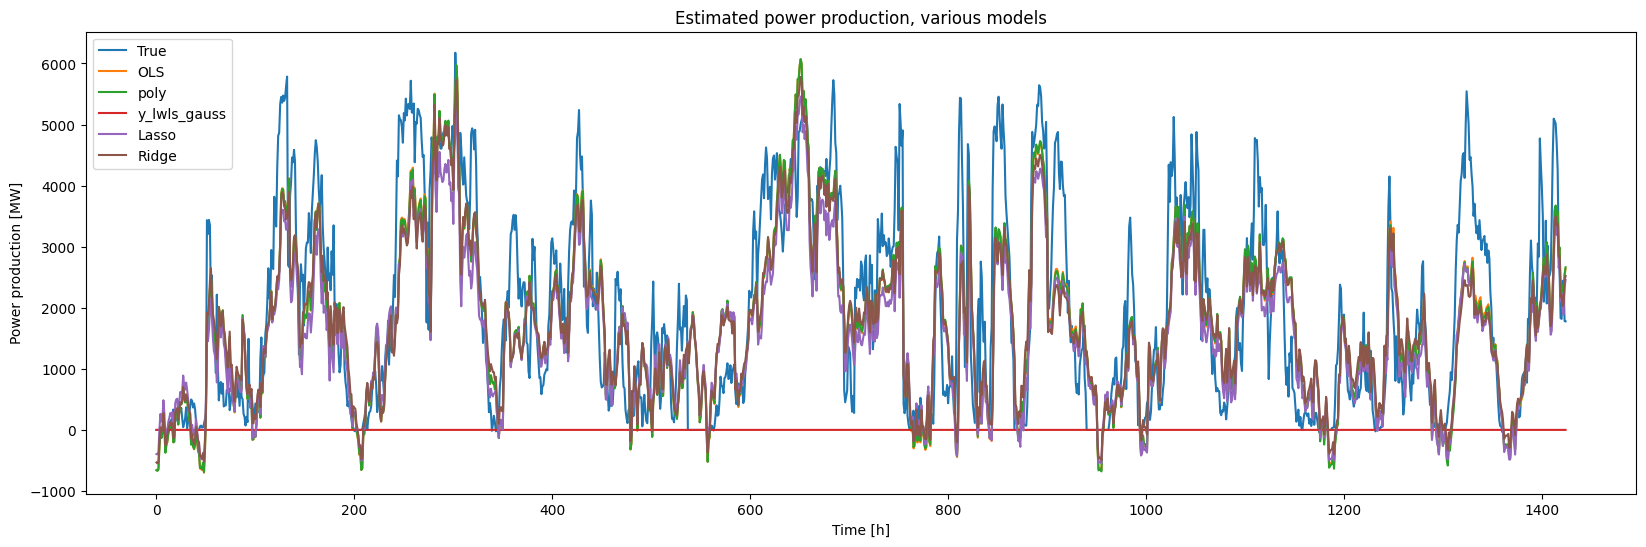

In [19]:
# Plot all predictions together with test data
plt.figure(figsize=(20, 6))
plt.plot(test_index, test_data['power'], label='True')
plt.plot(test_index, test_data['OLS'], label='OLS')
plt.plot(test_index, test_data['poly'], label='poly')
plt.plot(test_index, test_data['y_lwls_gauss'], label='y_lwls_gauss')
plt.plot(test_index, test_data['Lasso'], label='Lasso')
plt.plot(test_index, test_data['Ridge'], label='Ridge')
plt.legend()
plt.title('Estimated power production, various models')
plt.xlabel('Time [h]')
plt.ylabel('Power production [MW]')
plt.show()

In [20]:
def revenue(real, P_proj, lambda_DA, lambda_up, lambda_down):
    bid = market_bid(lambda_DA, lambda_up, lambda_down, P_proj)
    rev = np.sum(bid * lambda_DA + lambda_down * np.maximum(real - bid, 0) - lambda_up * np.maximum(bid - real, 0))
    return rev, bid



revenues = pd.DataFrame(index = [1], columns=model_names)
bids = pd.DataFrame(index = np.arange(len(test_data)), columns=model_names)


for model in model_names:
    revenues[model], bids[model] = revenue(test_data["power"].values, test_data[model].values, test_data["spotprice"].values, test_data["lambda_up"].values, test_data["lambda_down"].values)


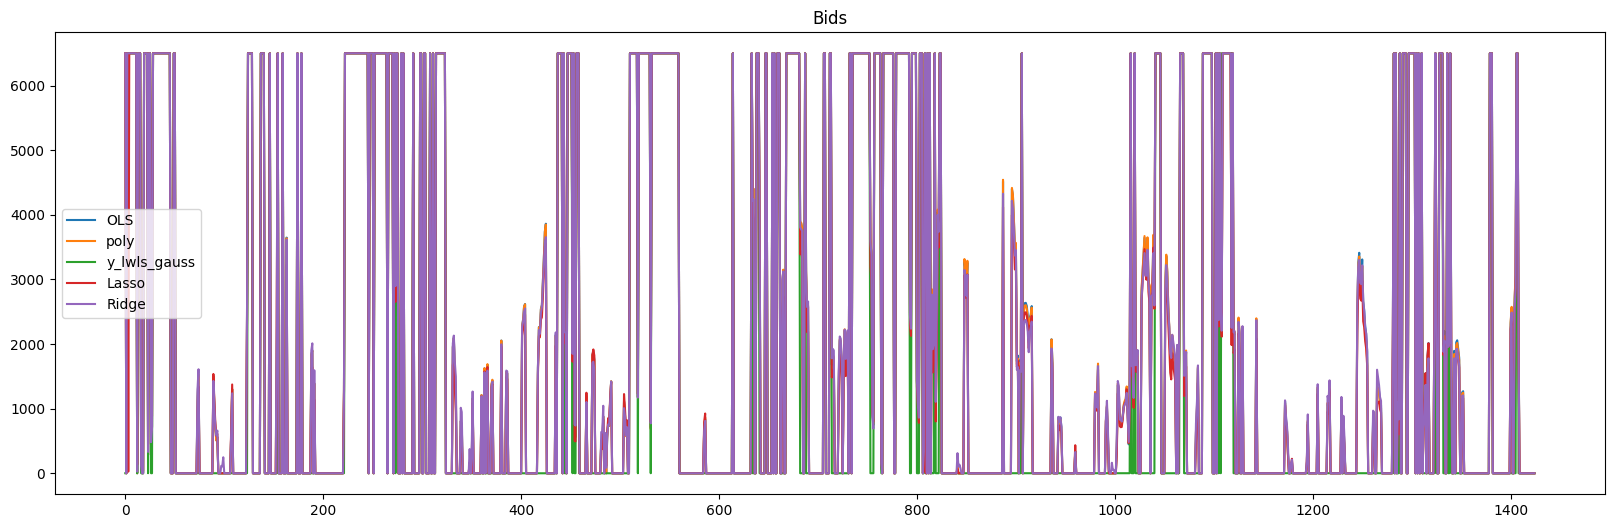

In [21]:
# Plot bids from original and modified model
plt.figure(figsize=(20, 6))
for model in model_names:
    plt.plot(bids[model], label=model)
plt.legend()
plt.title('Bids')
plt.show()

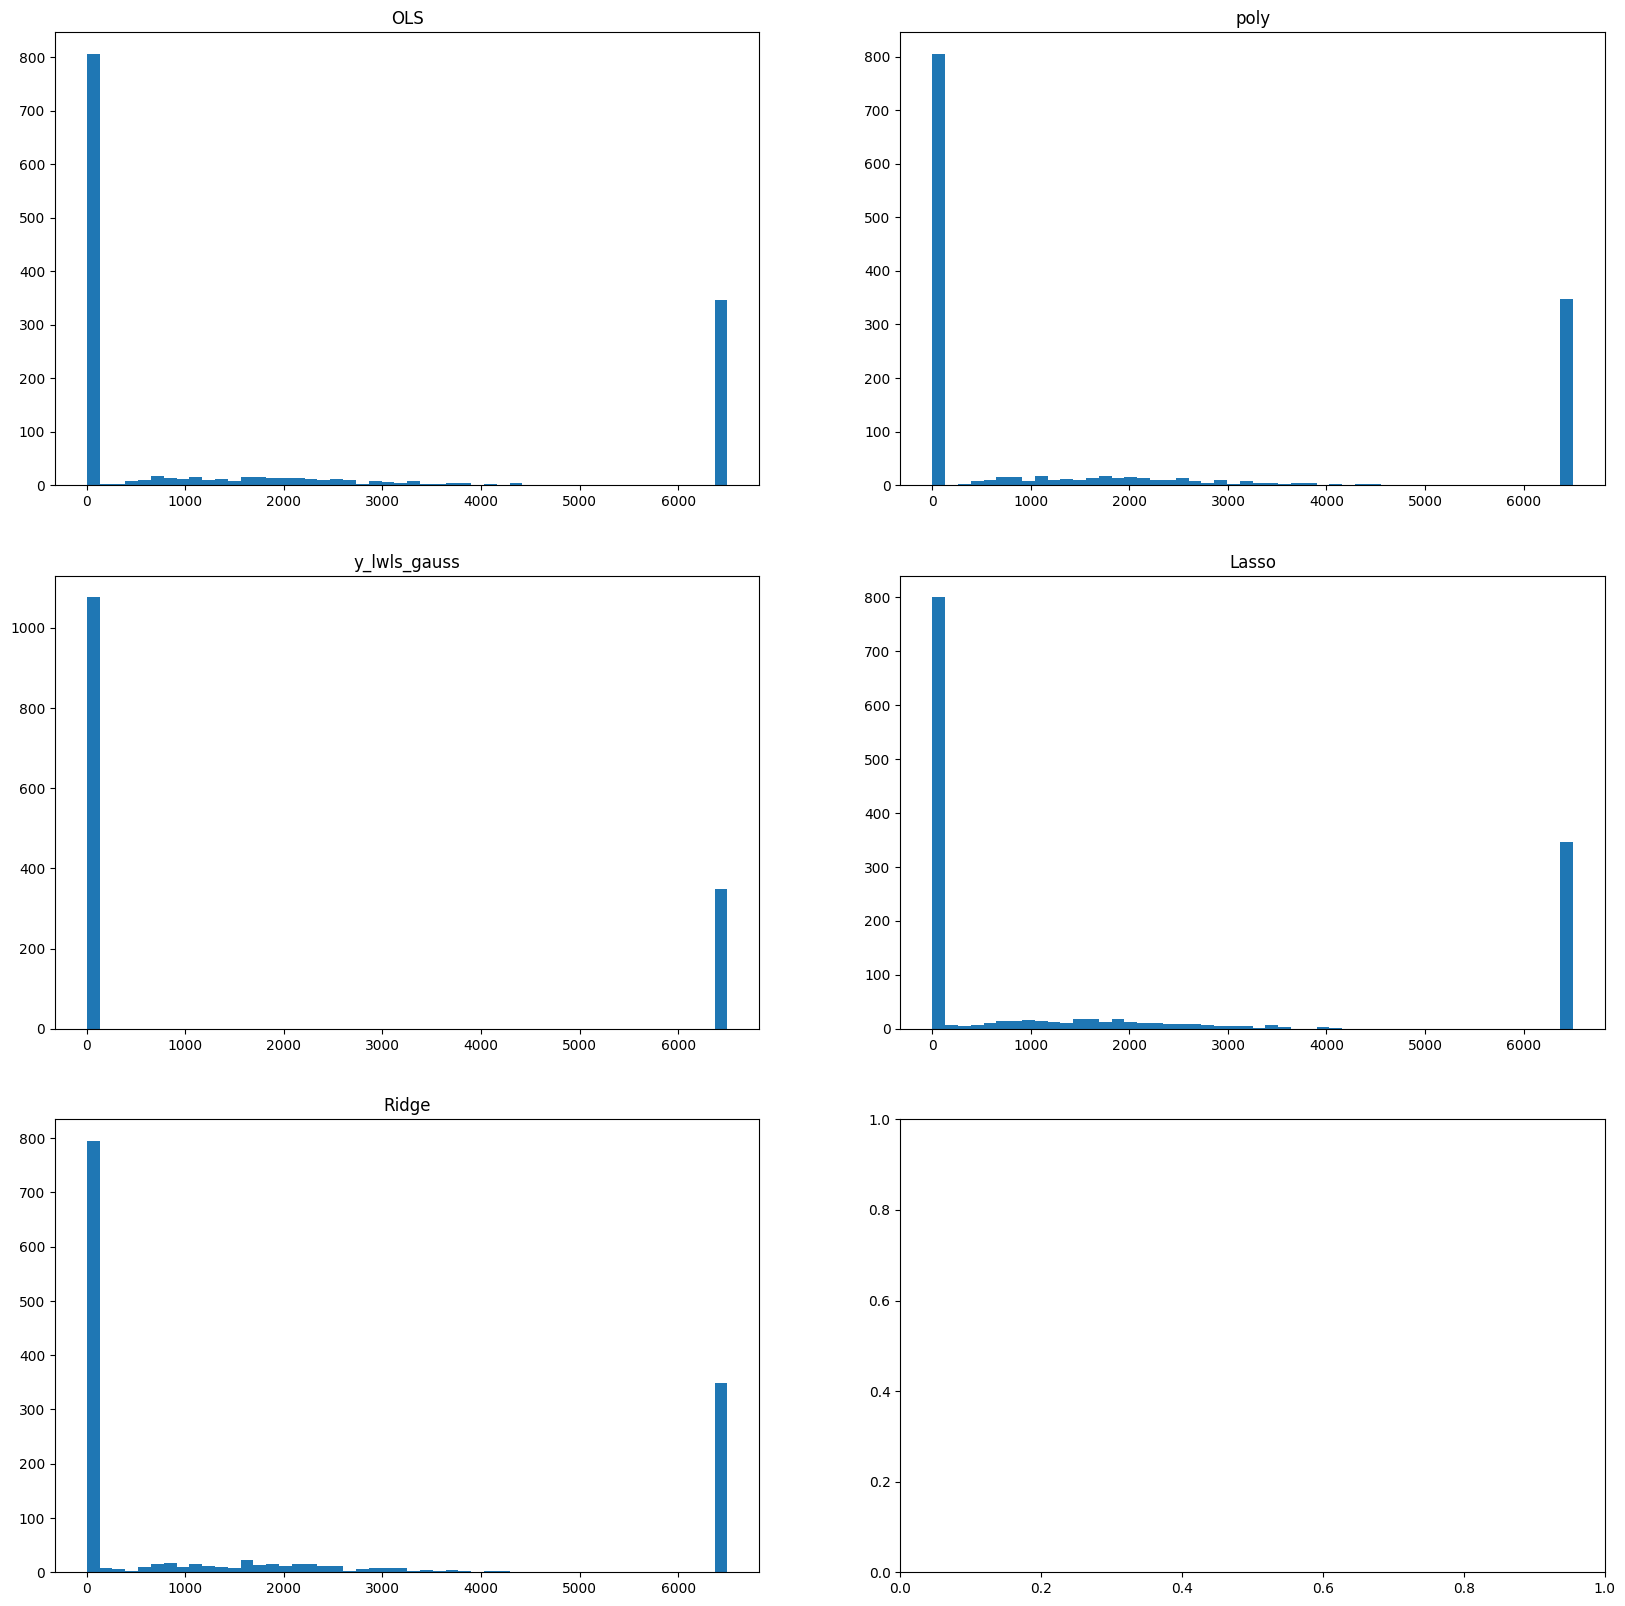

In [22]:
# Plot historgam of bids for each model in seperate subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for i, model in enumerate(model_names):
    axs[i//2, i%2].hist(bids[model], bins=50)
    axs[i//2, i%2].set_title(model)
plt.show()


## Task 7 (optional): Suggestion for improvement

In [55]:
"""
from sklearn.cluster import KMeans


# Implement clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(x).astype('int')

# Plot clusters
plt.scatter(x, y, c=clusters)
plt.show()

# Implement the elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()
"""

"\nfrom sklearn.cluster import KMeans\n\n\n# Implement clustering\nkmeans = KMeans(n_clusters=3, n_init=10, random_state=42)\nclusters = kmeans.fit_predict(x).astype('int')\n\n# Plot clusters\nplt.scatter(x, y, c=clusters)\nplt.show()\n\n# Implement the elbow method to find the optimal number of clusters\ninertia = []\nfor i in range(1, 11):\n    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)\n    kmeans.fit(x)\n    inertia.append(kmeans.inertia_)\nplt.plot(range(1, 11), inertia)\nplt.xlabel('Number of clusters')\nplt.ylabel('Inertia')\nplt.title('Elbow method')\nplt.show()\n"

## Task 8: Model 2
Predict power bids

C:\Users\jacob\AppData\Local\Temp\ipykernel_8556\3106247811.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstrs((lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] >= 0 for i in range(t)), "upward_nonzero")
C:\Users\jacob\AppData\Local\Temp\ipykernel_8556\3106247811.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.addConstrs((lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] >= 0 for i in range(t)), "downward_nonzero")
C:\Users\jacob\AppData\Local\Temp\ipykernel_8556\3106247811.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will 

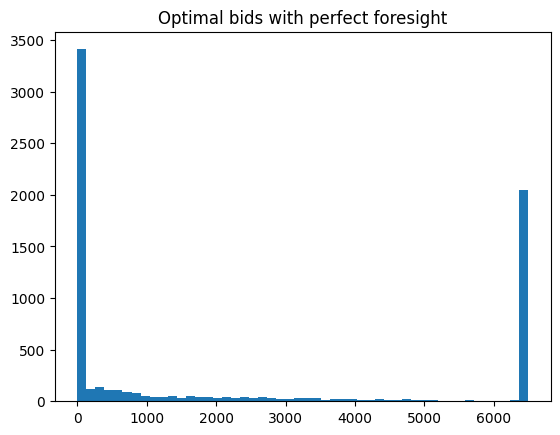

In [23]:
bids = market_bid(inputdata["spotprice"], inputdata["lambda_up"], inputdata["lambda_down"], inputdata["power"])
plt.hist(bids, bins = 50)
plt.title("Optimal bids with perfect foresight")
plt.show()

<Axes: >

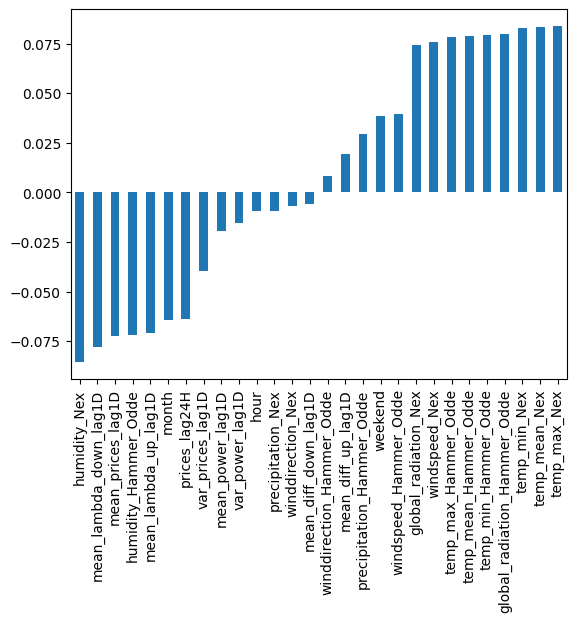

In [24]:
# Add optimal bids to inputdata
inputdata['opt_bids'] = bids

# Check correlation between features and optimal bids for relevant features
bid_features = inputdata.columns.drop(['power', 'spotprice', 'lambda_up', 'lambda_down'])

inputdata[bid_features].corr().loc["opt_bids"].drop("opt_bids").sort_values().plot(kind='bar')

In [25]:
y = inputdata['opt_bids']

# Keep only time features in x and replace hour, month, and weekend columns with one-hot encoding
x = inputdata[['hour', 'month', 'weekend']]
x = pd.get_dummies(x, columns=['hour', 'month', 'weekend'], drop_first=True)

In [26]:
# Split into training and test set
training_test_fraction = 0.8

# Make target binary for classification
y_bin = y > 3750

split_index_test = int(len(x) * training_test_fraction)
x_train, x_test = x[:split_index_test], x[split_index_test:]
y_train, y_test = y_bin[:split_index_test], y_bin[split_index_test:]

train_validation_fraction = 0.8
split_index_val = int(len(x_train) * train_validation_fraction)
x_train_train, x_train_val = x_train[:split_index_val], x_train[split_index_val:]
y_train_train, y_train_val = y_train[:split_index_val], y_train[split_index_val:]

In [27]:
# Create decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Create decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)

# Make predictions
y_pred = clf.predict(x_test)

# Calculate revenue
test_data = inputdata[inputdata.index.isin(y_test.index)]
lambda_DA = test_data['spotprice']
lambda_up = test_data['lambda_up']
lambda_down =test_data['lambda_down']
real = test_data["power"]
y = test_data['opt_bids']

revenue_perfect = np.sum(y * lambda_DA + lambda_down * np.maximum(real - y, 0) - lambda_up * np.maximum(y - real, 0))
revenue_pred = np.sum(6500*y_pred * lambda_DA + lambda_down * np.maximum(real - 6500*y_pred, 0)
                                              - lambda_up * np.maximum(6500*y_pred - real, 0))

print(f"Perfect revenue: {revenue_perfect}")
print(f"Predicted revenue using classification: {revenue_pred}")

# print difference
print(f"Difference in revenue: {revenue_perfect - revenue_pred}") # Check units pls

# Add perfect revenue and revenue from classification to revenues dataframe
revenues['Perfect'] = revenue_perfect
revenues['Classification'] = revenue_pred

Perfect revenue: 2040539211.2068431
Predicted revenue using classification: 1713933059.8129072
Difference in revenue: 326606151.3939359


We often face a (near) singular matrix in the closed form. Gradient descent is used instead

In [28]:
def gradient_descent(X_train, y_train, max_iterations=10000, alpha = 0.01):
    # Initial guess of coefficients
    theta = np.zeros(X_train.shape[1])

    # Number of observations
    m = len(X_train)
    
    for i in range(max_iterations):

        # Linear regression prediction
        h = theta @ X_train.T

        # The partial derivatives of the cost function
        dt = (1/m) * ((h - y_train.T) @ X_train)

        # Update the coefficients
        theta = theta - alpha * dt

        # Break if the change in coefficients is small
        if np.linalg.norm(alpha * dt) < 1e-6:
            print(i)
            return theta
        
    return theta

# Fit OLS
y = inputdata['opt_bids']
y_train, y_test = y[:split_index_test], y[split_index_test:]
theta_grad = gradient_descent(x_train, y_train, alpha=0.8)

7235


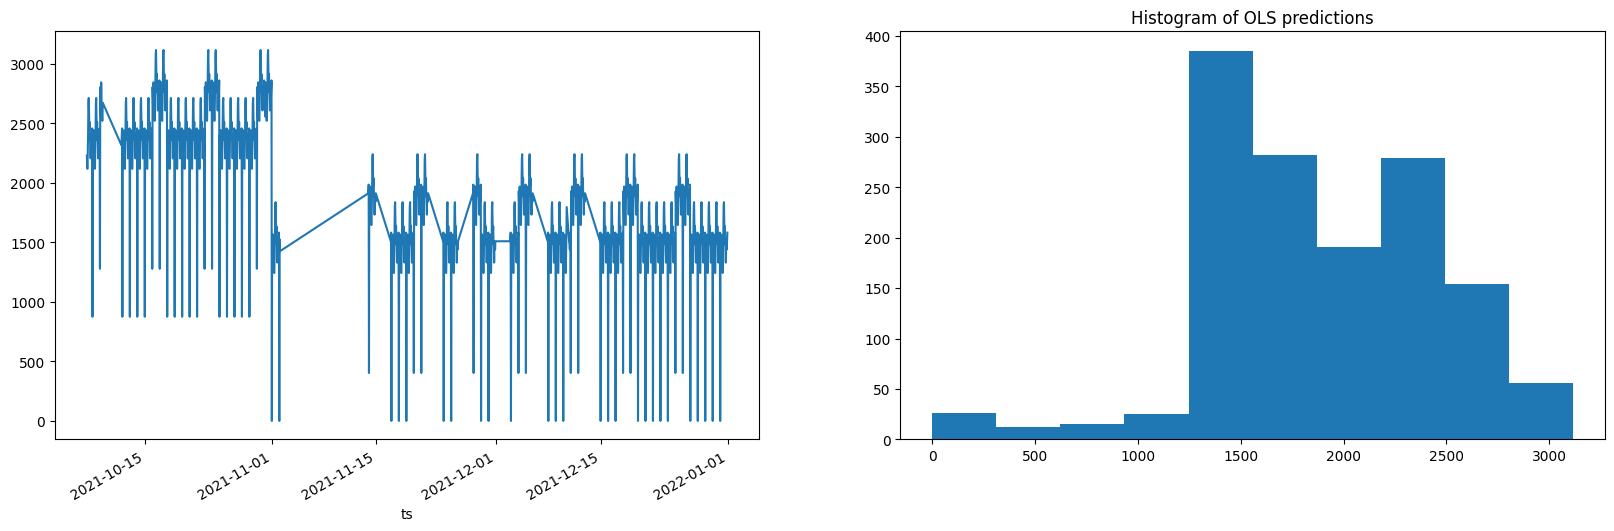

In [29]:
y_ols = theta_grad @ x_test.T
y_ols = np.maximum(y_ols, 0)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
y_ols.plot(ax = ax[0])
ax[1].hist(y_ols.values)
ax[1].set_title("Histogram of OLS predictions")
plt.show()

In [30]:
revenue_ols = np.sum(y_ols * lambda_DA + lambda_down * np.maximum(real - y_ols, 0)
                                       - lambda_up * np.maximum(y_ols - real, 0))
print(f"Revenue OLS: {revenue_ols}")

# Add OLS revenue to revenues dataframe
revenues['OLS_bids'] = revenue_ols

Revenue OLS: 1837802057.1532454


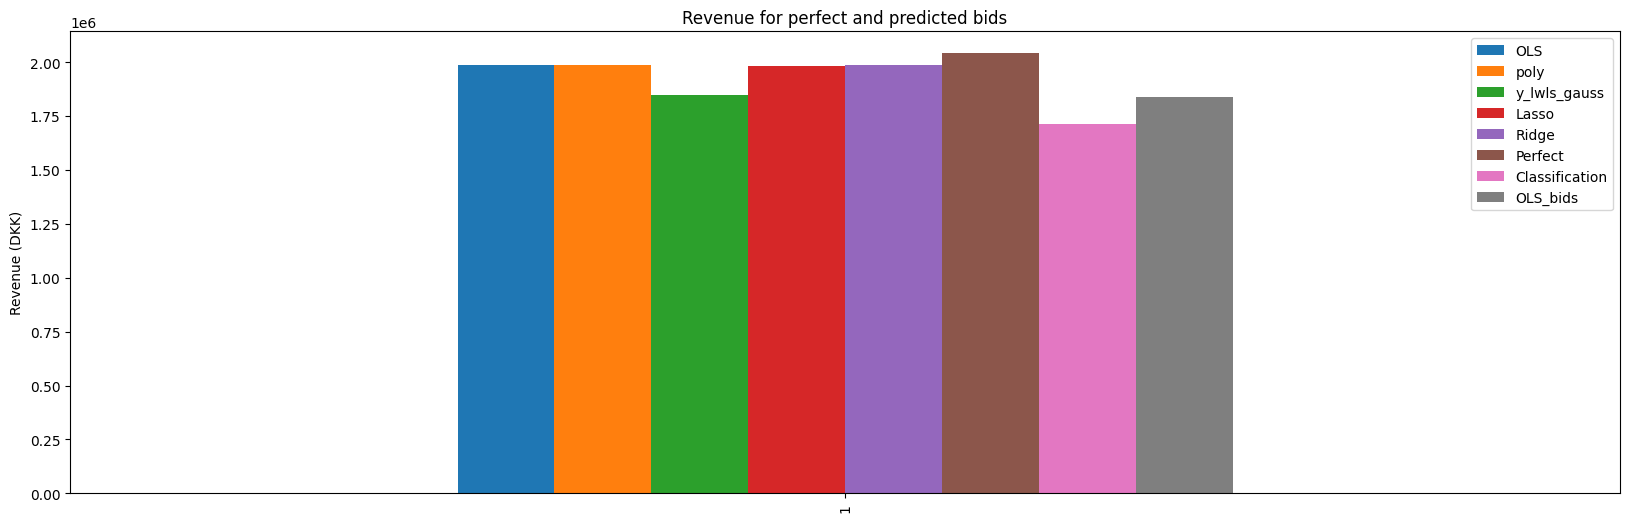

In [31]:
# Plot revenue for perfect and predicted bids from both classification and regression
plt.figure(figsize=(20, 6))
(revenues/1E3).plot(kind='bar', ax=plt.gca())
plt.ylabel('Revenue (DKK)')
plt.title('Revenue for perfect and predicted bids')
plt.show()